# Final project Karpov/сourses

Проект предстставляет собой тестовые задание одной крупной компании. Точные критерии оценивания неизвестны: задача – проявить себя как технически и методологически подготовленного специалиста. 

Менеджер, работающий в компании, специализирующейся на создании мобильных игр, обратился ко мне с запросом на исследование нескольких аспектов мобильного приложения:

1. Написать функцию для подсчета **retention**.
2. На основе данных **A/B-тестирования** наборов акционных предложений определить, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.
3. Предложить **метрики** для оценки результатов последнего прошедшего тематического события в игре.

In [1]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime
import time
import seaborn as sns
import matplotlib.pyplot as plt
from urllib.parse import urlencode
import requests
from scipy.stats import shapiro, chi2_contingency, norm, mannwhitneyu, ttest_ind
%matplotlib inline

# 1. Считывание, анализ и предобработка данных

In [2]:
df_reg = pd.read_csv('~/shared/problem1-reg_data.csv', sep=';')
df_auth = pd.read_csv('~/shared/problem1-auth_data.csv', sep=';')

### 1.1 Reg_data - данные о времени регистрации пользователей

In [3]:
df_reg.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


Таблица **df_reg** состоит из двух столбцов:
- **reg_ts** (registration timestamp) - дата регистрации пользователя в мобильном приложении в формате timestamp 
- **uid** (user id) - индентификационный номер пользователя 

In [4]:
df_reg.shape

(1000000, 2)

In [5]:
df_reg.nunique()

reg_ts    1000000
uid       1000000
dtype: int64

In [6]:
df_reg.isna().sum()

reg_ts    0
uid       0
dtype: int64

In [7]:
df_reg.dtypes

reg_ts    int64
uid       int64
dtype: object

- В датафреме **df_reg** нет пропущенных значений. 
- Дублирующихся значений индентификационного номера пользователя **uid** нет, следаовательно каждый пользователь регистрировался единожды.
- В столбце **reg_ts** хранится время регистрации каждого пользователя в формате **timestamp**. 

Посмотрим за какой период представлены данные в таблице **df_reg**

In [8]:
print(pd.to_datetime(df_reg.reg_ts.min(), unit='s'))
print(pd.to_datetime(df_reg.reg_ts.max(), unit='s'))

1998-11-18 09:43:43
2020-09-23 15:17:24


Данные представлены с 18 ноября 1998 года по 23 сентября 2020 года.

Добавим в датафрейм **df_reg** столбец с датой регистрации в формате **datetime**

In [9]:
df_reg['reg_date'] = pd.to_datetime(df_reg['reg_ts'].apply(lambda x: dt.date.fromtimestamp(x)))
df_reg.head()

,reg_ts,uid,reg_date
0,911382223,1,1998-11-18
1,932683089,2,1999-07-23
2,947802447,3,2000-01-14
3,959523541,4,2000-05-28
4,969103313,5,2000-09-16


Посмотрим на количество регистраций в каждом году и каждом месяце. 

Сгруппируем датафрейм **df_reg** по дате регистрации **reg_date** и посчитаем количество пользователей.

In [10]:
df_reg_by_date = df_reg.groupby('reg_date', as_index=False).agg(reg_count=('uid', 'count'))
df_reg_by_date.head()

,reg_date,reg_count
0,1998-11-18,1
1,1999-07-23,1
2,2000-01-14,1
3,2000-05-28,1
4,2000-09-16,1


Добавим к датафрейму **df_reg_by_date** столбцы с названием месяца **reg_month** и годом **reg_year**.

In [11]:
df_reg_by_date['reg_month'] = df_reg_by_date.reg_date.dt.strftime('%B')
df_reg_by_date['reg_year'] = df_reg_by_date.reg_date.dt.year
df_reg_by_date.head()

,reg_date,reg_count,reg_month,reg_year
0,1998-11-18,1,November,1998
1,1999-07-23,1,July,1999
2,2000-01-14,1,January,2000
3,2000-05-28,1,May,2000
4,2000-09-16,1,September,2000


Сгруппируем датафрейм **df_reg_by_date** по году регистрации **reg_year** и просуммируем количество регистраций. 

Построим график распределения количества регистраций в каждый год.

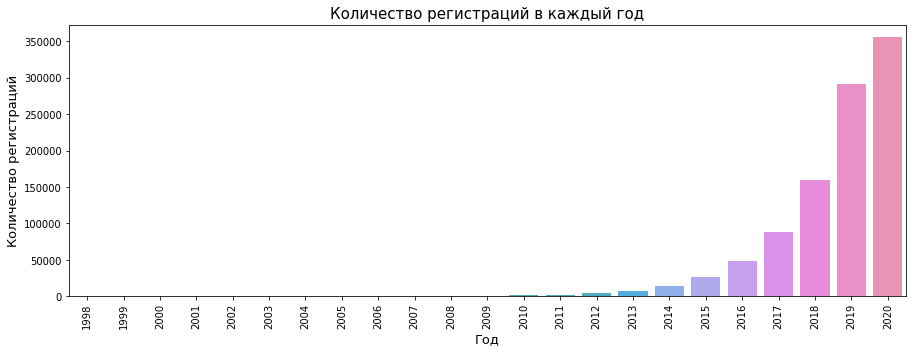

In [12]:
reg_by_year = df_reg_by_date.groupby(['reg_year'], as_index=False).agg({'reg_count': sum})
plt.figure(figsize=(15, 5))
ax = sns.barplot(data=reg_by_year, x='reg_year', y='reg_count')
plt.title("Количество регистраций в каждый год", fontsize=15)
ax.set_xlabel('Год', fontsize=13)
ax.set_ylabel('Количество регистраций', fontsize=13)
plt.xticks(rotation=90)
plt.show()

У игры положительная динамика по количеству регистраций от года к году

Сгруппируем датафрейм **df_reg_by_date** по названию месяца регистрации **reg_month** и найдём среднее количество регистраций. Построим график распределения количества регистраций в каждый месяц.

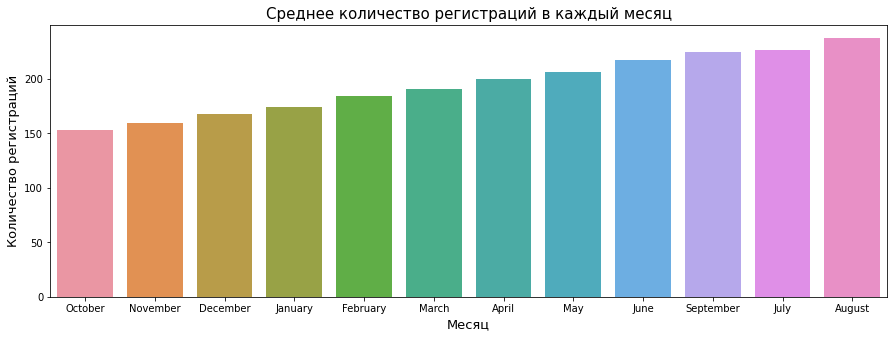

In [13]:
reg_by_month = df_reg_by_date.groupby('reg_month', as_index=False).reg_count.mean().sort_values('reg_count')
plt.figure(figsize=(15, 5))
ax = sns.barplot(data=reg_by_month, x='reg_month', y='reg_count')
plt.title("Среднее количество регистраций в каждый месяц", fontsize=15)
ax.set_xlabel('Месяц', fontsize=13)
ax.set_ylabel('Количество регистраций', fontsize=13)
plt.show()

- Среднее количество регистраций растёт линейно с октября до августа. 
- Самое большое среднее количество регистраций замечено с июня по сентябрь.

### 1.2 Auth_data - данные о времени захода пользователей в игру

In [14]:
df_auth.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


Таблица **df_auth** состоит из двух столбцов:
- **auth_ts** (authorization timestamp) - дата авторизации пользователя в мобильном приложении в формате timestamp 
- **uid** (user id) - индентификационный номер пользователя 

In [15]:
df_auth.shape

(9601013, 2)

In [16]:
df_auth.nunique()

auth_ts    9180915
uid        1000000
dtype: int64

In [17]:
df_auth.isna().sum()

auth_ts    0
uid        0
dtype: int64

In [18]:
df_auth.dtypes

auth_ts    int64
uid        int64
dtype: object

- В датафреме **df_auth** нет пропущенных значений. 
- В столбце **auth_ts** хранится время авторизации пользователя в формате **timestamp**. 
- Количество уникальных пользователей совпадает с количеством уникальных пользователей таблицы **df_reg**
- Количество авторизаций превышает количество пользователей, т.е. некоторые пользователи заходили в игру несколько раз.

Посчитаем для каждого пользователя количество заходов в игру

In [19]:
df_enter_count = df_auth.groupby('uid', as_index=False)\
                        .agg(enter_count=('auth_ts', 'count'))\
                        .sort_values('enter_count', ascending=False)
df_enter_count.head()

,uid,enter_count
1,2,1929
99,108,1397
148,158,1367
163,176,1331
175,191,1296


In [20]:
df_enter_count['enter_count'].describe()

count    1000000.000000
mean           9.601013
std           47.069539
min            1.000000
25%            1.000000
50%            1.000000
75%            1.000000
max         1929.000000
Name: enter_count, dtype: float64

Большинство пользователей авторизировались только 1 раз. Максимумальное количество авторизаций составляет 1929

Посчитаем количество пользователей, которые вошли в игру только 1 раз

In [21]:
df_enter_count.query('enter_count == 1').shape[0]

761622

Посмотрим какой процент пользователей входят в игру только 1 раз

In [22]:
100 * df_enter_count.query('enter_count == 1').shape[0] / df_enter_count.shape[0]

76.1622

**761.6** тыс. пользователей (**76.2**%) авторизируются только 1 раз

Посмотрим на распределение количества входов в игру, не беря в расчёт пользователей, которые вошли в игру только 1 раз

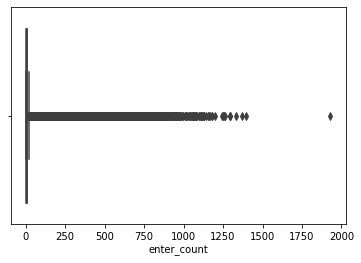

In [23]:
sns.boxplot(data = df_enter_count.query('enter_count > 1'), x = df_enter_count.query('enter_count > 1')['enter_count'])
plt.show()

In [24]:
df_enter_count.query('enter_count > 1')['enter_count'].describe()

count    238378.000000
mean         37.081404
std          91.119322
min           2.000000
25%           4.000000
50%           8.000000
75%          11.000000
max        1929.000000
Name: enter_count, dtype: float64

Создадим когорты пользователей, чтобы более наглядно посмотреть, как ведут себя пользователи в приложении.

Создадим список бинов и лейблов, а затем с помощью метода **pd.cut** разобьём столбец **enter_count** на бины, получившуюся серию добавим в датафрейм **df_enter_count**, в качестве столбца **auth_quantity_cohort**

In [25]:
my_labels = []
my_bins = [0, 1, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000]
for i in range(len(my_bins)-1):
    my_labels.append(f'от {my_bins[i] + 1} до {my_bins[i+1]}')
my_labels[0] = '1 раз'
df_enter_count['auth_quantity_cohort'] = pd.cut(df_enter_count['enter_count'], bins=my_bins, labels=my_labels)
df_enter_count.head()

,uid,enter_count,auth_quantity_cohort
1,2,1929,от 1001 до 2000
99,108,1397,от 1001 до 2000
148,158,1367,от 1001 до 2000
163,176,1331,от 1001 до 2000
175,191,1296,от 1001 до 2000


Сгруппируем получившийся датафрейм по когортам и посчитаем количество пользователей в каждой

In [26]:
df_auth_cohort = df_enter_count.groupby('auth_quantity_cohort', as_index=False).agg(users_count=('uid', 'count'))
df_auth_cohort

,auth_quantity_cohort,users_count
0,1 раз,761622
1,от 2 до 200,224885
2,от 201 до 300,6513
3,от 301 до 400,3452
4,от 401 до 500,1632
5,от 501 до 600,951
6,от 601 до 700,472
7,от 701 до 800,241
8,от 801 до 900,126
9,от 901 до 1000,54


Добавим столбец с количеством процентов от общего количества пользователей

In [27]:
df_auth_cohort['percent'] = (df_auth_cohort['users_count'] / df_reg.shape[0]).apply(lambda x: f'{str(round(100 * x, 4))} %')
df_auth_cohort

,auth_quantity_cohort,users_count,percent
0,1 раз,761622,76.1622 %
1,от 2 до 200,224885,22.4885 %
2,от 201 до 300,6513,0.6513 %
3,от 301 до 400,3452,0.3452 %
4,от 401 до 500,1632,0.1632 %
5,от 501 до 600,951,0.0951 %
6,от 601 до 700,472,0.0472 %
7,от 701 до 800,241,0.0241 %
8,от 801 до 900,126,0.0126 %
9,от 901 до 1000,54,0.0054 %


- Пользователи заходили в игру, как минимум 1 раз. 
- Причём большинтво пользователей 761.6 тыс. (**76%**) заходят в игру только **1** раз.
- 224.9 тыс. пользователей (**22.5%**) заходят в игру от **2** до **200** раз.
- Пользователь id **2** авторизовался в игре максимальное количество раз - **1929**

Посмотрим за какой период представлены данные в таблице **df_auth**

In [28]:
print(pd.to_datetime(df_auth.auth_ts.min(), unit='s'))
print(pd.to_datetime(df_auth.auth_ts.max(), unit='s'))

1998-11-18 09:43:43
2020-09-23 15:17:24


Данные представлены с 18 ноября 1998 года по 23 сентября 2020 года. Проверим на равенство первые и последние даты регистрации и авторизации

In [29]:
print(df_reg.reg_ts.min() == df_auth.auth_ts.min())
print(df_reg.reg_ts.max() == df_auth.auth_ts.max())

True
True


Получается, чтобы до конца пройти процесс регистрации пользователь должен авторизироваться в приложении.

Посмотрим на сезонность авторизации пользователей. Добавим в датафрейм **df_auth** столбец с датой регистрации в формате **datetime**

In [30]:
df_auth['auth_date'] = pd.to_datetime(df_auth['auth_ts'].apply(lambda x: dt.date.fromtimestamp(x)))
df_auth.head()

,auth_ts,uid,auth_date
0,911382223,1,1998-11-18
1,932683089,2,1999-07-23
2,932921206,2,1999-07-25
3,933393015,2,1999-07-31
4,933875379,2,1999-08-05


Посмотрим на количество регистраций в каждом году и каждом месяце. 

Сгруппируем датафрейм **df_auth** по дате авторизации **auth_date** и посчитаем количество пользователей.

In [31]:
df_auth_by_date = df_auth.groupby('auth_date', as_index=False).agg(auth_count=('uid', 'count'))
df_auth_by_date.head()

,auth_date,auth_count
0,1998-11-18,1
1,1999-07-23,1
2,1999-07-25,1
3,1999-07-31,1
4,1999-08-05,1


Добавим к получившемуся датафрейму столбцы с названием месяца **auth_month** и годом **auth_year**.

In [32]:
df_auth_by_date['auth_month'] = df_auth_by_date.auth_date.dt.strftime('%B')
df_auth_by_date['auth_year'] = df_auth_by_date.auth_date.dt.year

Сгруппируем датафрейм **df_auth_by_date** по году авторизации **auth_year** и просуммируем количество авторизаций. Построим график распределения количества авторизаций в каждый год.

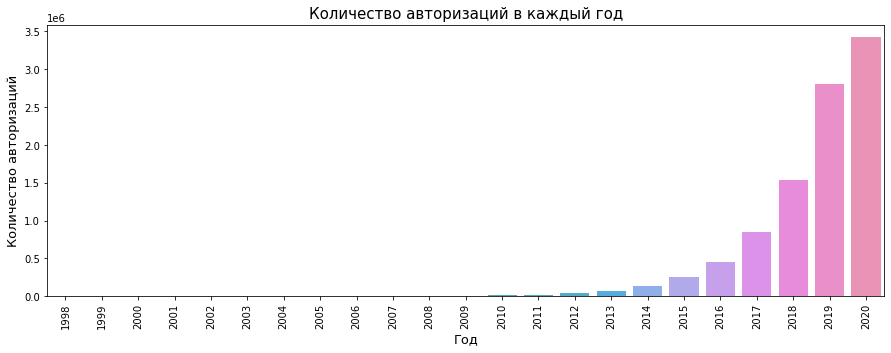

In [33]:
auth_by_year = df_auth_by_date.groupby(['auth_year'], as_index=False).agg({'auth_count': sum})
plt.figure(figsize=(15, 5))
ax = sns.barplot(data=auth_by_year, x='auth_year', y='auth_count')
plt.title("Количество авторизаций в каждый год", fontsize=15)
ax.set_xlabel('Год', fontsize=13)
ax.set_ylabel('Количество авторизаций', fontsize=13)
plt.xticks(rotation=90)
plt.show()

Посмотрим на это же распределение не беря в расчёт 1-ую дату авторизации. Учитывая, что у каждого пользователя была первая дата авторизации при регистрации, вычтем из столбца **auth_count** единицу. Запишем получившуюся серию в столбец **ACWR**(Authorizations Count Without Registrations). И построим график распределения данной метрики.

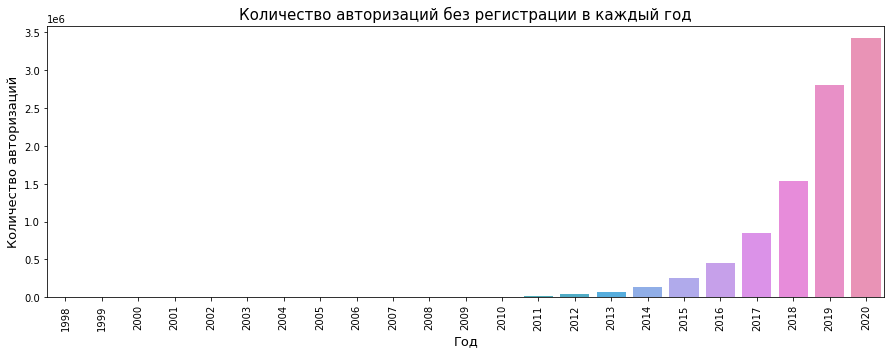

In [34]:
df_auth_by_date['ACWR'] = df_auth_by_date['auth_count'] - 1
auth_by_year = df_auth_by_date.groupby(['auth_year'], as_index=False).agg({'ACWR': sum})
plt.figure(figsize=(15, 5))
ax = sns.barplot(data=auth_by_year, x='auth_year', y='ACWR')
plt.title("Количество авторизаций без регистрации в каждый год", fontsize=15)
ax.set_xlabel('Год', fontsize=13)
ax.set_ylabel('Количество авторизаций', fontsize=13)
plt.xticks(rotation=90)
plt.show()

У игры положительная динамика по количеству авторизаций от года к году

Сгруппируем датафрейм **df_auth_by_date** по месяцу авторизации **auth_month** и найдём среднее количество авторизаций. Построим график распределения количества авторизаций в каждый месяц.

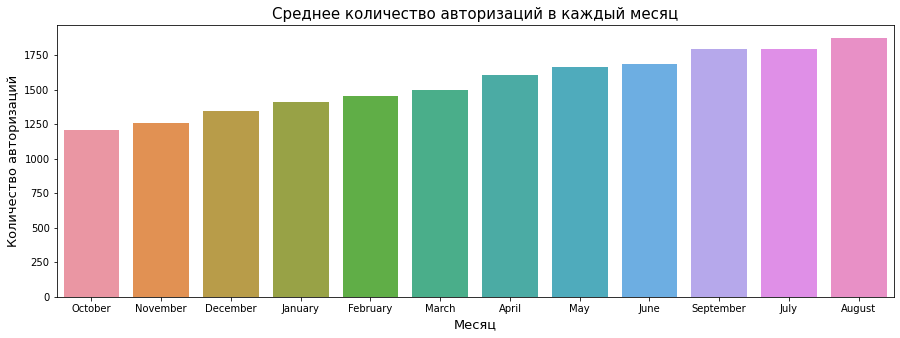

In [35]:
auth_by_month = df_auth_by_date.groupby('auth_month', as_index=False).ACWR.mean().sort_values('ACWR')
plt.figure(figsize=(15, 5))
ax = sns.barplot(data=auth_by_month, x='auth_month', y='ACWR')
plt.title("Среднее количество авторизаций в каждый месяц", fontsize=15)
ax.set_xlabel('Месяц', fontsize=13)
ax.set_ylabel('Количество авторизаций', fontsize=13)
plt.show()

- Среднее количество авторизаций растёт линейно с октября до августа. 
- Самое большое среднее количество авторизаций замечено с июня по сентябрь.

# 1.3 Анализ объединённого датафрейма

Перед объединением датафреймов проверим совпадают ли id пользователей **uid** в таблицах **df_reg** и **df_auth**

In [36]:
set(df_auth['uid'].unique()) == set(df_reg['uid'].unique())

True

Пользовательские id в двух датафремах совпадают. 

Объединим датафреймы **df_auth** и **df_reg** в один **full_users_data** для дальнейшего анализа.

In [37]:
full_users_data = df_auth.merge(df_reg, on='uid', how='left').sort_values(['uid', 'auth_ts'])
full_users_data.head()

,auth_ts,uid,auth_date,reg_ts,reg_date
0,911382223,1,1998-11-18,911382223,1998-11-18
1,932683089,2,1999-07-23,932683089,1999-07-23
2,932921206,2,1999-07-25,932683089,1999-07-23
3,933393015,2,1999-07-31,932683089,1999-07-23
4,933875379,2,1999-08-05,932683089,1999-07-23


Проверим корректность объединения, сверив количество строк в получившемся датафрейме **full_users_data** и датафрейме **df_auth**, они должны быть равны

In [38]:
full_users_data.shape[0] == df_auth.shape[0]

True

Оставим в датафрейме только необходимые для дальнейшего анализа столбцы. 

In [39]:
full_users_data = full_users_data[['uid', 'reg_date', 'auth_date']]
full_users_data.head()

,uid,reg_date,auth_date
0,1,1998-11-18,1998-11-18
1,2,1999-07-23,1999-07-23
2,2,1999-07-23,1999-07-25
3,2,1999-07-23,1999-07-31
4,2,1999-07-23,1999-08-05


Соберём сводную таблицу с данными по каждому году.

Посчитаем количество регистраций в каждый год. Сгруппируем датафрейм **full_users_data** по году и посчитаем количество уникальных id пользователей

In [40]:
df_annual_analysis = full_users_data.query('reg_date == auth_date')\
                                    .groupby(full_users_data.reg_date.dt.year)\
                                    .agg(reg_count=('uid', 'nunique'))
df_annual_analysis.head()

,reg_count
reg_date,
1998,1
1999,1
2000,4
2001,6
2002,10


Добавим в датафрейм **df_annual_analysis** столбец с накопительной суммой **reg_users**, чтобы знать сколько пользователей зарегистрировались в игре на текущий год

In [41]:
df_annual_analysis['reg_users'] = df_annual_analysis['reg_count'].cumsum()
df_annual_analysis.head()

,reg_count,reg_users
reg_date,,
1998,1,1
1999,1,2
2000,4,6
2001,6,12
2002,10,22


Добавим в датафрейм **df_annual_analysis** столбец с подсчётом количества авторизаций пользователями. Не будем брать в расчёт дни регистрации пользователей.

In [42]:
df_annual_analysis['auth_count'] = full_users_data.query('reg_date != auth_date')\
                                                    .groupby(full_users_data.reg_date.dt.year)\
                                                    .agg(reg_count=('uid', 'count'))
df_annual_analysis.head()

,reg_count,reg_users,auth_count
reg_date,,,
1998,1,1,NaN
1999,1,2,1928.0
2000,4,6,NaN
2001,6,12,NaN
2002,10,22,24.0


В столбце **auth_count** присутствуют пропущенные значения, это значит, что в эти года никто не заходил в приложение (помимо регистрации) заполним эти ячейки нулями

In [43]:
df_annual_analysis = df_annual_analysis.fillna(0)

Рассчитаем среднее количество авторизаций на одного зарегистрированного пользователя в каждом году, для этого разделим значения столбца **auth_count** на значения столбца **reg_users**

In [44]:
df_annual_analysis['mean_auth'] = df_annual_analysis['auth_count'] / df_annual_analysis['reg_users']
df_annual_analysis

,reg_count,reg_users,auth_count,mean_auth
reg_date,,,,
1998,1,1,0.0,0.000000
1999,1,2,1928.0,964.000000
2000,4,6,0.0,0.000000
2001,6,12,0.0,0.000000
2002,10,22,24.0,1.090909
2003,20,42,29.0,0.690476
2004,35,77,61.0,0.792208
2005,65,142,1473.0,10.373239
2006,119,261,9169.0,35.130268


Построим график изменения количества авторизаций на одного пользователя по годам

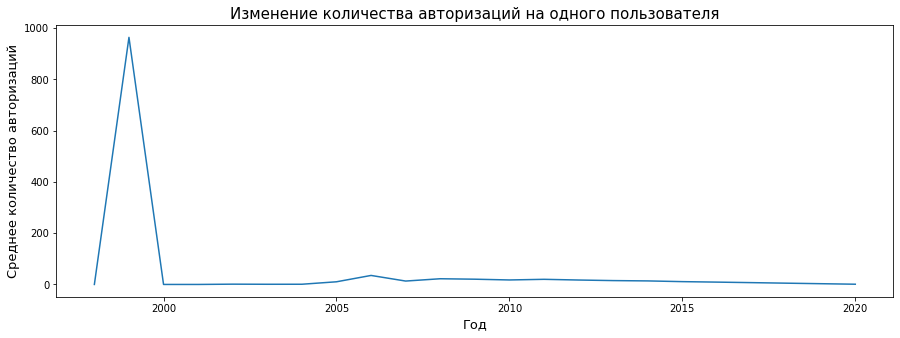

In [45]:
plt.figure(figsize=(15, 5))
ax = sns.lineplot(y=df_annual_analysis['mean_auth'], x=[i for i in range(1998, 2021)])
plt.title("Изменение количества авторизаций на одного пользователя", fontsize=15)
ax.set_xlabel('Год', fontsize=13)
ax.set_ylabel('Среднее количество авторизаций', fontsize=13)
plt.show()

In [46]:
df_annual_analysis['mean_auth'].describe()

count     23.000000
mean      51.628075
std      199.103549
min        0.000000
25%        0.989455
50%       10.373239
75%       17.370940
max      964.000000
Name: mean_auth, dtype: float64

- Медианное значение количества авторизаций на одного пользователя составило 10.4. 
- С 2008 года данная метрика начала снижатся и за 12 лет упала до 0.9	

Проверим какое время проходит между авторизациями. Оставим в датафрейме **full_users_data** только те строки, где дата регистрации и авторизации не совпадают. Затем добавим в датафрейм  колонку с количеством дней от регистрации до текущего входа в игру **DBRA** (Days Between Registration and Authorization)

In [47]:
df_DBRA = full_users_data.query('reg_date != auth_date').reset_index(drop=True)
df_DBRA['DBRA'] = (df_DBRA['auth_date'] - df_DBRA['reg_date']).dt.days
df_DBRA.head()

,uid,reg_date,auth_date,DBRA
0,2,1999-07-23,1999-07-25,2
1,2,1999-07-23,1999-07-31,8
2,2,1999-07-23,1999-08-05,13
3,2,1999-07-23,1999-08-11,19
4,2,1999-07-23,1999-08-15,23


Теперь для каждого пользователя найдём первый вход в игру, последний вход в игру и количество входов

In [48]:
user_reg_auth = df_DBRA.groupby('uid', as_index=False).agg(first_auth=('DBRA', min),
                                                      last_auth=('DBRA', max),
                                                      count_auth=('DBRA', 'count'))
user_reg_auth.head()

,uid,first_auth,last_auth,count_auth
0,2,2,7728,1928
1,15,4,50,10
2,18,4,12,3
3,21,6,24,6
4,22,5,17,5


Для каждого пользователя посчитаем среднее количество дней между входами в игру, как разность между последним входом в игру и первым входом делённым на количество входов.

In [49]:
user_reg_auth['mean_reg_auth'] = (user_reg_auth['last_auth'] - user_reg_auth['first_auth']) / user_reg_auth['count_auth']

Посмотрим на распределение среднего количества дней между авторизациями

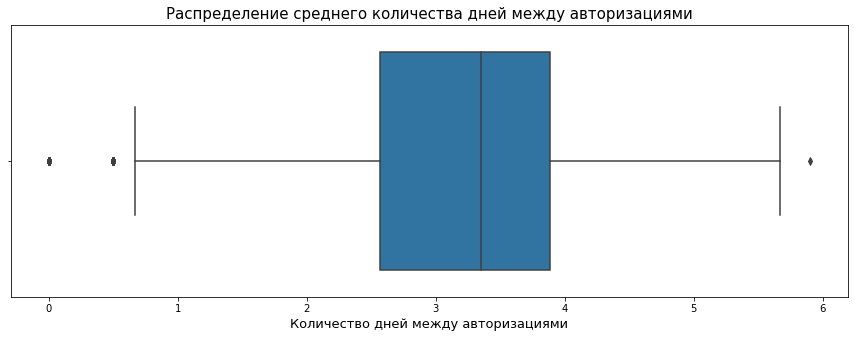

In [50]:
plt.figure(figsize=(15, 5))
ax = sns.boxplot(data=user_reg_auth, x=user_reg_auth['mean_reg_auth'])
plt.title("Распределение среднего количества дней между авторизациями", fontsize=15)
ax.set_xlabel('Количество дней между авторизациями', fontsize=13)
plt.show()

In [51]:
user_reg_auth['mean_reg_auth'].describe()

count    238378.000000
mean          3.015812
std           1.216213
min           0.000000
25%           2.571429
50%           3.353890
75%           3.888889
max           5.900000
Name: mean_reg_auth, dtype: float64

- Медианное среднее количество дней между входами в игру составляет 3 дня
- Максимальное среднее количество дней между входами в игру составило 6 дней

Посмотрим на максимальное количество дней между сессиями.

In [52]:
(df_DBRA['DBRA'] - df_DBRA['DBRA'].shift(1)).max()

7.0

Максимальное количество между сессиями равно 7 дням.

Посчитаем сколько пользователей заходят в игру через 1, 2, ... 7 дней после последней авторизации.

Добавим в датафрейм **full_users_data** столбцы **DBRA** и **DBA** (Days Between Authorization). Неверные значения количества дней будут находиться в тех строках, где дата авторизации совпадает с датой регистрации, эти строки в анализе не понадобятся.

In [53]:
full_users_data['DBRA'] = (full_users_data['auth_date'] - full_users_data['reg_date']).dt.days
full_users_data['DBA'] = full_users_data['DBRA'] - full_users_data['DBRA'].shift(1)
df_DBA = full_users_data.query('reg_date != auth_date')

Проверим значения столбца **DBA**

In [54]:
df_DBA['DBA'].describe()

count    8.601013e+06
mean     3.995070e+00
std      1.779316e+00
min      1.000000e+00
25%      2.000000e+00
50%      4.000000e+00
75%      5.000000e+00
max      7.000000e+00
Name: DBA, dtype: float64

Сгруппируем датафрейм **full_users_data** по столбцу **DBA** и посчитаем количество авторизаций. Также добавим столбец, в который запишем, процент от общего количества авторизаций

In [55]:
DBA = df_DBA.groupby('DBA').agg(auth_count=('uid', 'count'))
DBA['percent'] = 100 * DBA['auth_count'] / DBA['auth_count'].sum()
DBA

,auth_count,percent
DBA,,
1.0,718747,8.356539
2.0,1439248,16.733471
3.0,1437189,16.709532
4.0,1431951,16.648632
5.0,1431740,16.646179
6.0,1428635,16.610078
7.0,713503,8.295569


### Выводы по анализу данных:

1. В данных нет пропущенных значений.
- Каждый пользователь заходит в игру, как минимум 1 раз при регистрации, причём 76% пользователей заходят в игру только 1 раз. 22.5% пользователей заходят в игру от 2 до 200 раз.
- Пользователь id **2** авторизовался в игре максимальное количество раз - **1929**
- У игры положительная динамика по количеству авторизаций и регистраций от года к году. 
- Самое большое среднее количество регистраций и авторизаций замечено с июня по сентябрь.
- С 2011 года количество авторизаций на одного зарегистрированного пользователя начало падать с 20 до 0.9.
- Медианное количество дней между входами в игру составляет 3 дня (16.7% авторизаций, не считая авторизацию при регистрации).
- Максимальное количество между сессиями равно 7 дням (8.3% авторизаций не считая авторизацию при регистрации).

# 2. Написать функцию для расчёта retention

Для начала воспользуемся уже готовым датафреймом из предыдущего пункта **full_users_data**. 

Возьмём выборку поменьше, для разработки алгоритма расчёта retantion. Оставим в датафрейме пользователей, зарегистрировавшихся в **2020** году, так как это последний записанный год в данных, также в этот год было самое большое количество входов в игру и самое большое количество зарегистрировавшихся пользователей.

In [56]:
reg_auth_2020 = full_users_data.query('reg_date.dt.year == 2020')
reg_auth_2020.head()

,uid,reg_date,auth_date,DBRA,DBA
6182273,716202,2020-01-01,2020-01-01,0,-27.0
6182287,716203,2020-01-01,2020-01-01,0,0.0
6211873,716203,2020-01-01,2020-01-03,2,2.0
6281245,716203,2020-01-01,2020-01-10,9,7.0
6313698,716203,2020-01-01,2020-01-13,12,3.0


Посмотрим на динамику входов в игру в 2020 году по месяцам

In [57]:
reg_auth_2020.groupby(reg_auth_2020.reg_date.dt.month)\
                .agg(users_count=('uid', 'nunique'),
                     auth_count=('auth_date', 'count'))\
                .sort_values(['auth_count'], ascending=False)\
                .reset_index().rename(columns={'reg_date': 'reg_month'})

,reg_month,users_count,auth_count
0,1,33726,173676
1,3,37224,166036
2,2,33146,156386
3,4,37875,154516
4,5,41151,151990
5,6,41871,135903
6,7,45493,131665
7,8,47872,116702
8,9,36738,56223


Для пробного построения метрики **Retantion** воспользуемся январём 2020 года, т.к. в этом месяце самое большое количество входов в игру.

Оставим в тестовом датафрейме только те строки, в которых дата регистрации произошла позже начала января 2020 года, а дата авторизации ранее конца января 2020 года

In [58]:
reg_auth_test = reg_auth_2020.query('reg_date >= "2020-01-01" & auth_date <= "2020-01-31"')

Определим количество пользователей, которые зарегистрировались в одну дату и зашли в игру через определённое количество дней. Для этого сгруппируем датафрейм **reg_auth_test** по столбцам даты регистрации **reg_date** и количеством дней от даты регистрации до авторизации **DBRA**. Также изменим тип данных столбца **reg_date** в тип **str** для дальнейшей визуализации.

In [59]:
df_return_count = reg_auth_test.groupby(['reg_date','DBRA'], as_index=False).agg(users_return_count=('uid', 'nunique'))
df_return_count['reg_date'] = df_return_count['reg_date'].astype(str)
df_return_count.head()

,reg_date,DBRA,users_return_count
0,2020-01-01,0,1061
1,2020-01-01,1,28
2,2020-01-01,2,45
3,2020-01-01,3,46
4,2020-01-01,4,46


Создадим сводную таблицу, строками в которой будут даты регистрации **reg_date**, колонками - разница в днях между датой регистрации и датой авторизации **DBRA**, а значениями - количество пользователей **users_return_count**

In [60]:
df_retantion = df_return_count.pivot(index='reg_date', columns='DBRA', values='users_return_count')
df_retantion.head()

DBRA,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
reg_date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,1061.0,28.0,45.0,46.0,46.0,76.0,76.0,63.0,50.0,46.0,...,45.0,41.0,29.0,40.0,34.0,41.0,40.0,31.0,35.0,23.0
2020-01-02,1063.0,26.0,41.0,51.0,51.0,62.0,70.0,70.0,54.0,53.0,...,37.0,50.0,43.0,38.0,32.0,40.0,37.0,36.0,31.0,NaN
2020-01-03,1065.0,21.0,44.0,50.0,52.0,70.0,77.0,59.0,52.0,48.0,...,41.0,38.0,34.0,36.0,37.0,31.0,27.0,30.0,NaN,NaN
2020-01-04,1067.0,20.0,42.0,53.0,62.0,61.0,70.0,54.0,49.0,48.0,...,32.0,36.0,34.0,30.0,32.0,34.0,22.0,NaN,NaN,NaN
2020-01-05,1068.0,19.0,57.0,44.0,51.0,51.0,79.0,58.0,52.0,52.0,...,45.0,30.0,47.0,35.0,39.0,34.0,NaN,NaN,NaN,NaN


Расчитаем **Retantion**, разделив значения столбцов на значения нулевого столбца

In [61]:
df_retantion = df_retantion.divide(df_retantion[0], axis=0).apply(lambda x: round(100 * x, 2))
df_retantion.head()

DBRA,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
reg_date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,100.0,2.64,4.24,4.34,4.34,7.16,7.16,5.94,4.71,4.34,...,4.24,3.86,2.73,3.77,3.20,3.86,3.77,2.92,3.30,2.17
2020-01-02,100.0,2.45,3.86,4.80,4.80,5.83,6.59,6.59,5.08,4.99,...,3.48,4.70,4.05,3.57,3.01,3.76,3.48,3.39,2.92,NaN
2020-01-03,100.0,1.97,4.13,4.69,4.88,6.57,7.23,5.54,4.88,4.51,...,3.85,3.57,3.19,3.38,3.47,2.91,2.54,2.82,NaN,NaN
2020-01-04,100.0,1.87,3.94,4.97,5.81,5.72,6.56,5.06,4.59,4.50,...,3.00,3.37,3.19,2.81,3.00,3.19,2.06,NaN,NaN,NaN
2020-01-05,100.0,1.78,5.34,4.12,4.78,4.78,7.40,5.43,4.87,4.87,...,4.21,2.81,4.40,3.28,3.65,3.18,NaN,NaN,NaN,NaN


Найдём максимальное значение **Retantion** не считая нулевого столбца (100%) для корректной цветовой схемы тепловой карты

In [62]:
max_value = df_retantion.drop(0, axis=1).max().max()
max_value

8.86

Построим тепловую карту **Retantion**

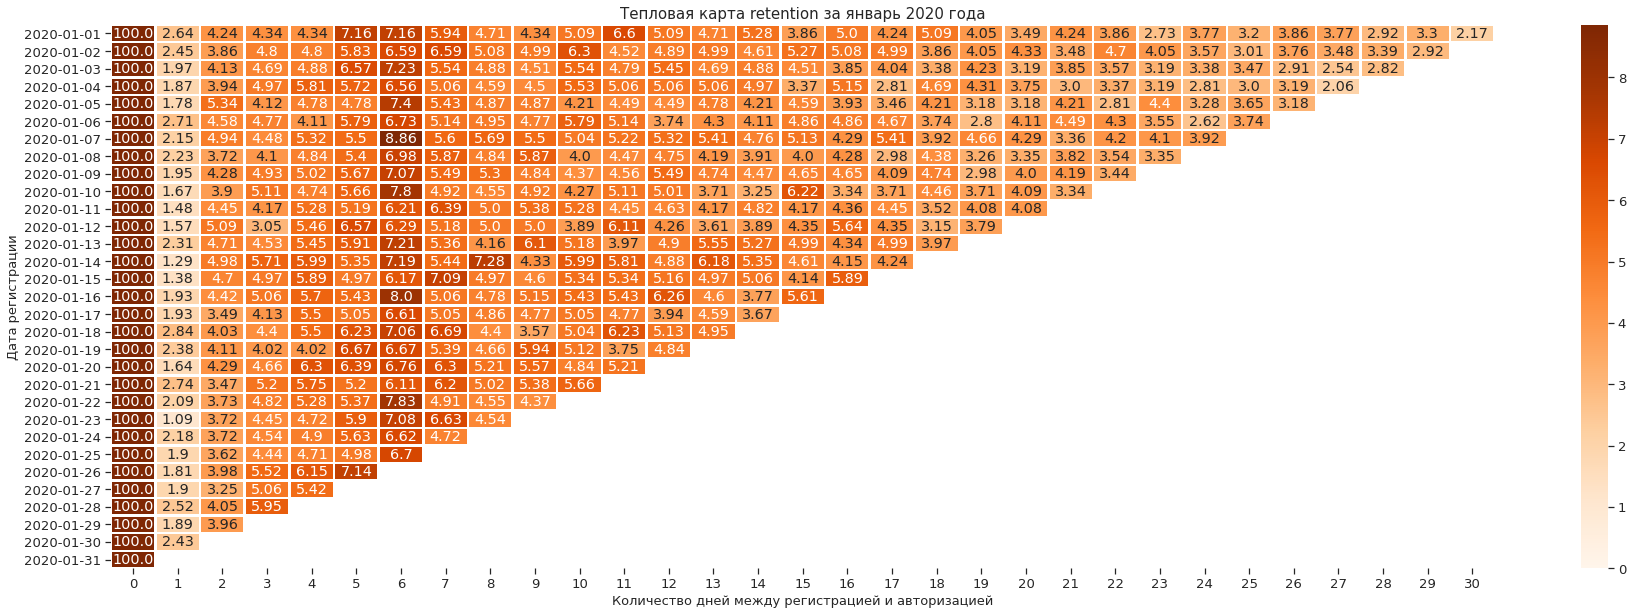

In [63]:
plt.figure(figsize=(31, 10))
sns.set(style='ticks', font_scale=1.2)
ax = sns.heatmap(df_retantion, annot=True, vmin=0.0, vmax=max_value, fmt='', linewidths = 1.5, cmap="Oranges")
plt.title("Тепловая карта retention за январь 2020 года", fontsize=15)
ax.set_xlabel('Количество дней между регистрацией и авторизацией', fontsize=13)
ax.set_ylabel('Дата регистрации', fontsize=13)
plt.show()

### Функция для определения Retantion

Напишем функция для расчёта retantion, основываясь на разработанном выше алгоритме

In [64]:
def get_retention_rate(start_time: str, 
                       finish_time=datetime.now().strftime('%Y-%m-%d'), 
                       limit_days=None,
                       reg_file_path='~/shared/problem1-reg_data.csv', 
                       auth_file_path='~/shared/problem1-auth_data.csv'):
    '''Функция принимает на вход начальную дату отслеживания retantion - start_time, 
    конечную дату отслеживания retantion - finish_time,
    необходимое количество исследуемых дней с момента регистрации пользователем limit_days,
    путь к файлу с регистрациями пользователей - reg_file_path, 
    путь к файлу с авторизациями пользователей - auth_file_path.
    Функция возвращает тепловую карту с retantion.
    '''
    #  Считываем оба датафрейма
    df_reg = pd.read_csv(reg_file_path, sep=';')
    df_auth = pd.read_csv(auth_file_path, sep=';')
    
    #  На всякий случай удаляем из датафреймов пропущенные строки
    df_reg.dropna(inplace=True)
    df_auth.dropna(inplace=True)
   
    #  Объединяем два датафрейма в один
    full_users_data = df_auth.merge(df_reg, on='uid', how='left').sort_values(['uid', 'auth_ts'])
    
    #  Добавим колонки с датами регистрации и авторизации пользователем
    lambda_func = lambda x: dt.date.fromtimestamp(x)
    full_users_data['reg_date'] = pd.to_datetime(full_users_data['reg_ts'].apply(lambda_func))
    full_users_data['auth_date'] = pd.to_datetime(full_users_data['auth_ts'].apply(lambda_func))
    
    #  Оставим в датафрейме только необходимые данные
    full_users_data = full_users_data.query('reg_date >= @start_time & auth_date <= @finish_time')
        
    #  Добавим колонку с количеством дней от регистрации до авторизации
    full_users_data['DBRA'] = (full_users_data['auth_date'] - full_users_data['reg_date']).dt.days
    
    #  Убираем из датафрейма строки, где количество дней от момента регистрации за пределами исследуемой области
    if limit_days:
        full_users_data = full_users_data.query('DBRA <= @limit_days')
    
    #  Для каждого дня из выбранного диапазона определим количество зарегистрировавшихся пользователей
    #  Определим количество пользователей, которые зарегистрировались в одну дату 
    #  и зашли в игру через определённое количество дней                                          
    df_return_count = full_users_data.groupby(['reg_date','DBRA'], as_index=False).agg(users_return_count=('uid', 'nunique'))
        
    #  Изменим тип столбца reg_date                                           
    df_return_count['reg_date'] = df_return_count['reg_date'].astype(str)
    
    #  Создадим сводную таблицу
    df_retantion = df_return_count.pivot(index='reg_date', columns='DBRA', values='users_return_count')
    
    #  Рассчитаем Retantion 
    df_retantion = df_retantion.divide(df_retantion[0], axis=0).apply(lambda x: round(100 * x, 2))
    
    #  Найдём максимальное значение Retantion не считая 100%
    max_value = df_retantion.drop(0, axis=1).max().max()       
    
    # Строим тепловую карту
    plt.figure(figsize=(31, 10))
    sns.set(style='ticks', font_scale=1.2)
    ax = sns.heatmap(df_retantion, annot=True, vmin=0.0, vmax=max_value, fmt='', linewidths = 1.5, cmap="Oranges")
    if limit_days:
        plt.title(f"Тепловая карта retention (период {start_time} - {finish_time}, ограничение по количеству дней - {limit_days})", fontsize=15)
    else:
        plt.title(f"Тепловая карта retention (период {start_time} - {finish_time}", fontsize=15)
    plt.title(f"Тепловая карта retention (период {start_time} - {finish_time})", fontsize=15)
    ax.set_xlabel('Количество дней между регистрацией и авторизацией', fontsize=13)
    ax.set_ylabel('Дата регистрации', fontsize=13)
    plt.show()
    pass

Проверим работу функции

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


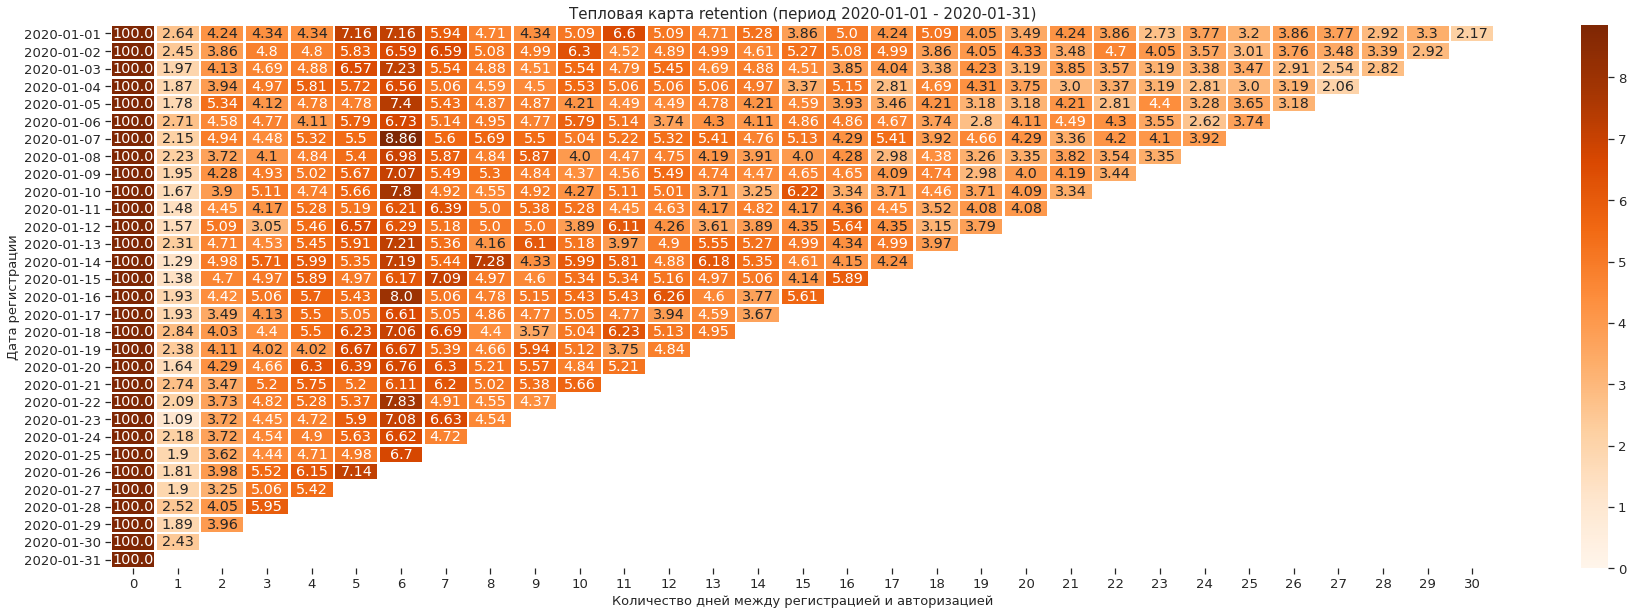

In [65]:
#  Тест №1
get_retention_rate("2020-01-01", "2020-01-31")

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


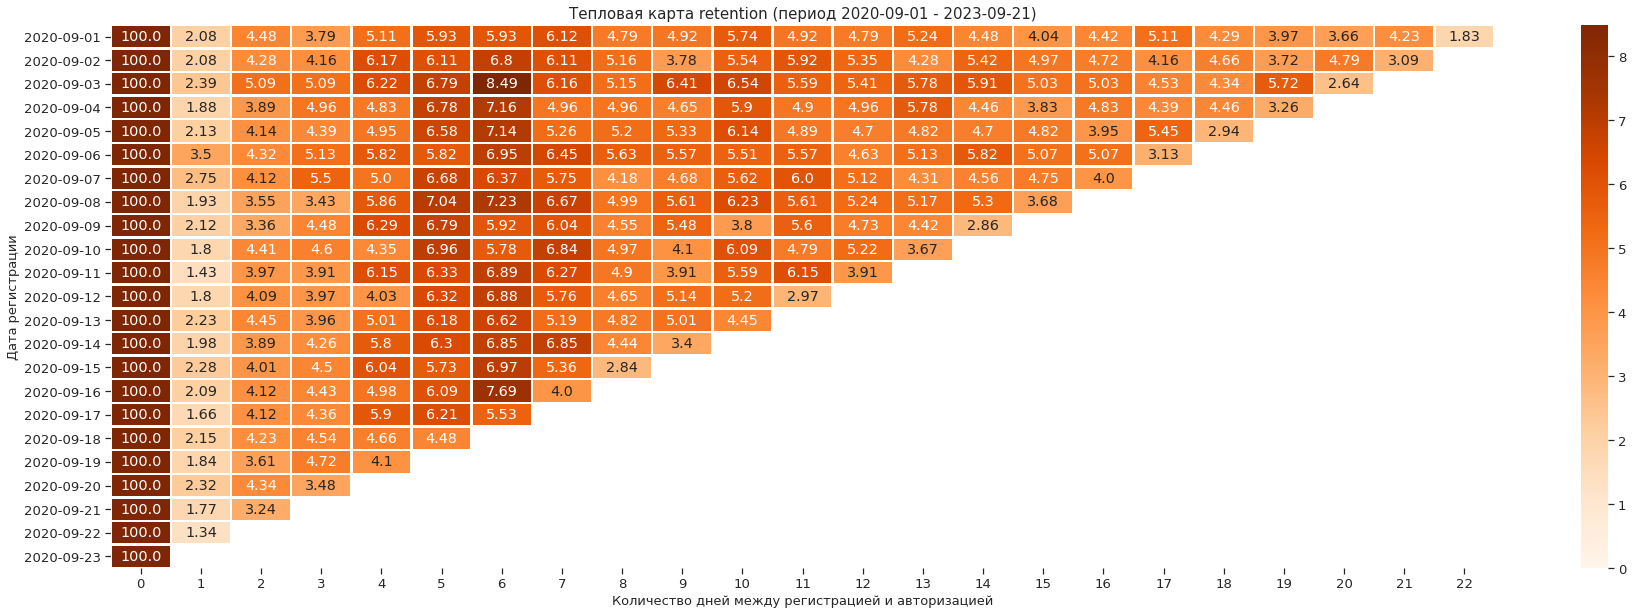

In [66]:
#  Тест №2
get_retention_rate('2020-09-01')

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


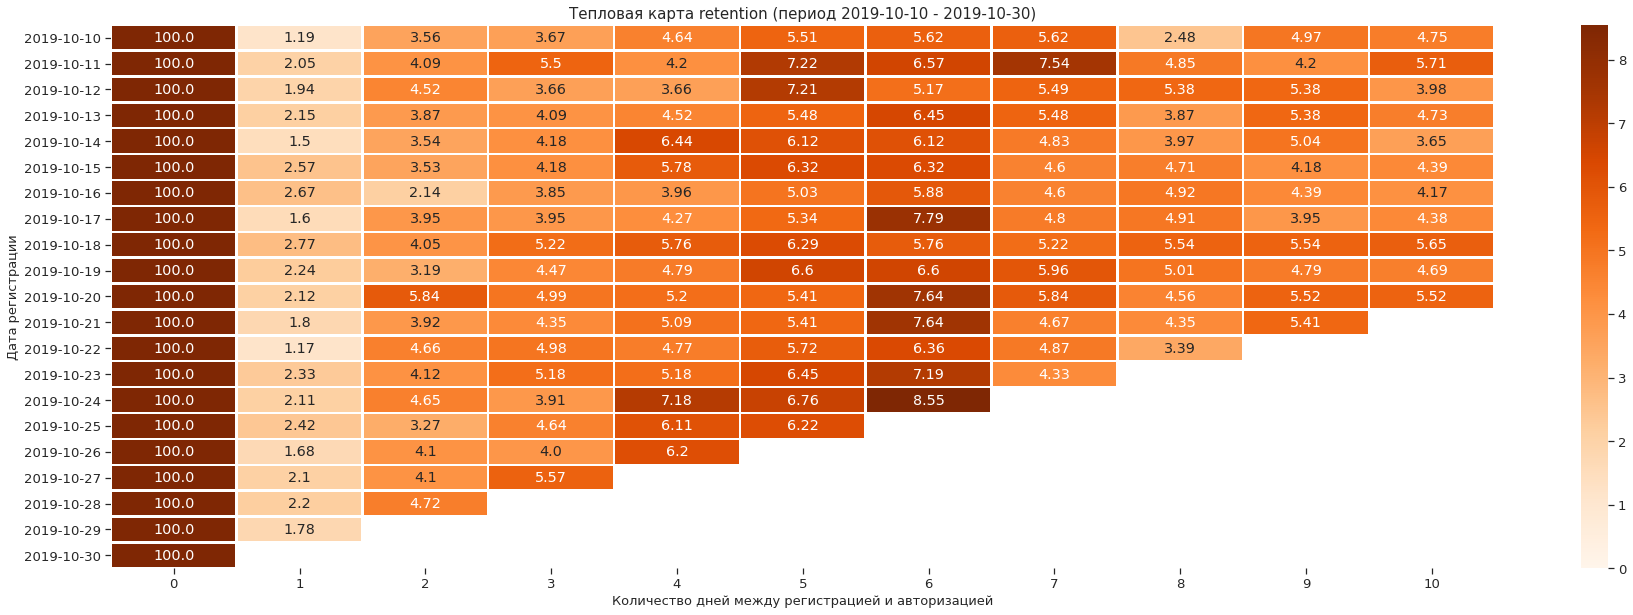

In [67]:
#  Тест №3
get_retention_rate('2019-10-10', finish_time='2019-10-30', limit_days=10)

### Вывод:

В результате выполнения задания была написана и протестирована фунция по расчёту Retantion. 

Данная функция позволяет выбрать любой диапазон данных. Для работы функции в её аргументы достаточно передать:
- дату начала расчёта retantion **start_time**, 
- финальную дату **finish_time**(если не указать, функция возьмёт текущую дату), 
- количество дней для ограничения расчёта retantrion **limit_days** (необязательно),
- два пути к файлам **reg_file_path** и **auth_file_path**. 

Если исследуемый файл всегда расположен в одной директории, пропишите этот путь как стандартный в функцию.

# 3. A/B-тестирование

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667. Необходимо ответить на следующие вопросы: какой набор предложений можно считать лучшим и какие метрики стоит проанализировать для принятия правильного решения и как?

### Считывание данных

In [68]:
path_to_file = 'https://disk.yandex.ru/d/SOkIsD5A8xlI7Q'
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
final_url = base_url + urlencode(dict(public_key=path_to_file))
response = requests.get(final_url)
download_url = response.json()['href']

In [69]:
df_AB = pd.read_csv(download_url, sep=';')
df_AB.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [70]:
df_AB.shape

(404770, 3)

In [71]:
df_AB.nunique()

user_id      404770
revenue        1477
testgroup         2
dtype: int64

In [72]:
df_AB.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

In [73]:
df_AB.dtypes

user_id       int64
revenue       int64
testgroup    object
dtype: object

In [74]:
df_AB.describe()

,user_id,revenue
count,404770.000000,404770.000000
mean,202385.500000,26.083435
std,116847.178567,681.652928
min,1.000000,0.000000
25%,101193.250000,0.000000
50%,202385.500000,0.000000
75%,303577.750000,0.000000
max,404770.000000,37433.000000


Посмотрим на количество пользователей и общий доход в тестовой и конторольной группах

In [75]:
df_AB.groupby('testgroup').agg(users_count=('user_id', 'count'),
                              total_revenue=('revenue','sum'))

,users_count,total_revenue
testgroup,,
a,202103,5136189
b,202667,5421603


- В получеом датафрейме нет пропущенных значений
- Количество уникальных пользователей совпадает с количеством строк
- В контрольной группе 202103 пользователя
- В тестовой группе 202667 пользователей
- Общий доход в тестовой группе на 5.6% больше, чем в контрольной

В качестве метрик для анализа A/B теста и принятия правильного решения, считаю необходимым выбор следующих метрик:

- **ARPU** - средний доход от одного пользователя
- **ARPPU** - средний доход от одного платящего пользователя
- **Конвесия в покупку** - отношение количества платящих пользователей к общему количеству пользователей


### ARPU


Посмотрим на распределение **revenue**. 

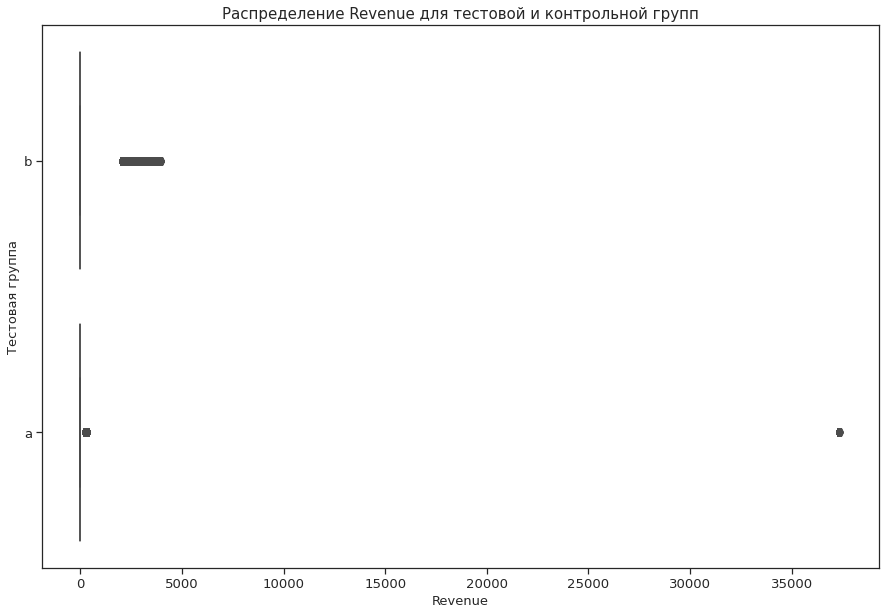

In [76]:
plt.figure(figsize=(15, 10))
ax = sns.boxplot(data=df_AB, x='revenue', y='testgroup')
plt.title("Распределение Revenue для тестовой и контрольной групп", fontsize=15)
ax.set_xlabel('Revenue', fontsize=13)
ax.set_ylabel('Тестовая группа', fontsize=13)
plt.show()

В контрольной группе есть выбросы, которые могут исказить результаты анализа  метрики **ARPU**. Посмотрим на пользователей, которые принесли прибыль больше 35 тыс.

In [77]:
df_most_revenuer = df_AB.query('revenue > 35000')
df_most_revenuer.user_id.count()

123

In [78]:
100 * 123 / 5136189

0.002394771687724108

Посмотрим, какой общий доход они принесли

In [79]:
df_most_revenuer.revenue.sum()

4590252

In [80]:
100*4590252/5136189

89.37077665950378

**123** (**0.002%**) пользователя контрольной группы принесли большую часть прибыли (**89.4%**), для простоты будем называть их далее **уникальные пользователи**. Ради интереса, проверим их даты регистрации, использовав датасэт из предыдущего задания (выводы делать по этому анализу некорректно, т.к. неизвестно id пользователей в этих двух датафреймах совпадают или нет)

Для начала добавим к датасету **df_AB** данные из датафрейма **df_reg**

In [81]:
AB_reg_date = df_AB.merge(df_reg, left_on='user_id', right_on='uid')

Выведем минимальную и максимальную даты регистрации пользователей в контрольной и тестовой группах

In [82]:
AB_reg_date.groupby('testgroup').agg(first_reg=('reg_date', min),
                                    last_reg=('reg_date', max))

,first_reg,last_reg
testgroup,,
a,1999-07-23,2019-01-19
b,1998-11-18,2019-01-19


Разница в начальных датах регистрации пользователей тестовой и контрольной групп составляет почти год, по идее из этого можно сделать вывод, что выборки могут быть нерепрезентативны.

Посмотрим теперь на даты регистрации платящих пользователей

In [83]:
AB_reg_date.query('revenue > 0')\
            .groupby('testgroup')\
            .agg(first_reg=('reg_date', min),
                 last_reg=('reg_date', max))

,first_reg,last_reg
testgroup,,
a,2004-10-10,2019-01-19
b,2006-02-03,2019-01-18


Данных пользователей можно условно назвать "новыми". Можно сделать вывод, что до 2004 года не было возможности монетизировать приложение.

А теперь посмотрим на даты регистрации пользователей контрольной группы, которые принесли большую часть прибыли

In [84]:
AB_reg_date.query('revenue > 35000')\
            .groupby('testgroup')\
            .agg(first_reg=('reg_date', min),
                 last_reg=('reg_date', max))

,first_reg,last_reg
testgroup,,
a,2007-08-11,2019-01-10


Дата первой регистрации **уникальных пользователей** была в 2007 году. Ещё раз повторюсь, что выводы делать из этого **НЕЛЬЗЯ**, просто было интересно провести такой анализ.

По боксплотам распределения **Revenue** для тестовой и контрольной групп видно, что распределения не являются нормальными, но на всякий случай построим распределение **ARPU** и проверим выборки на нормальность **критерием Шапиро-Уилка**.

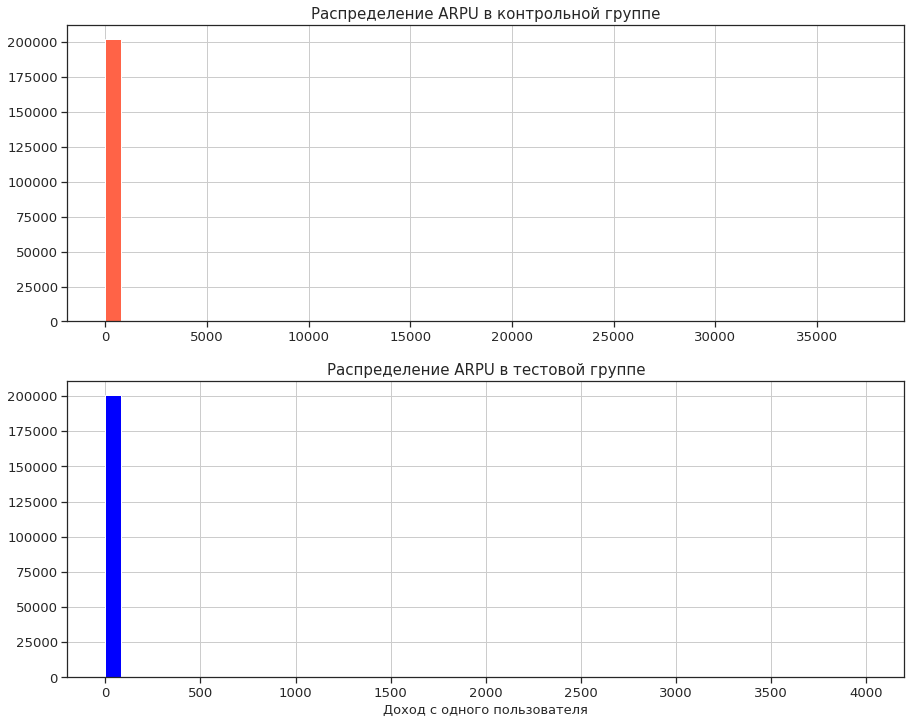

In [85]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(15, 12))
df_AB.query('testgroup == "a"').revenue.hist(ax=axs[0], color='Tomato', bins=50)
axs[0].set_title('Распределение ARPU в контрольной группе', fontsize=15)
df_AB.query('testgroup == "b"').revenue.hist(ax=axs[1], color='Blue', bins=50)
axs[1].set_title('Распределение ARPU в тестовой группе', fontsize=15)
axs[1].set_xlabel('Доход с одного пользователя', fontsize=13)
plt.show()

Обозначим гипотезы для проверки на нормальность распределения **критерием Шапиро-Уилка**:

**H0** - распределение метрики **ARPU** является нормальным

**H1** - распределение метрики **ARPU** не является нормальным

В качестве уровня значимости **α** выберем значение 0.05

In [86]:
shapiro(df_AB.query('testgroup == "a"').revenue).pvalue

/opt/tljh/user/lib/python3.7/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


0.0

In [87]:
shapiro(df_AB.query('testgroup == "b"').revenue).pvalue

0.0

**P-value** для обоих тестов меньше 0.05, это позволяет отвергнуть нулевую гипотезу. Значит распределения **ARPU** в обеих группах не являются нормальными. Для нахождения статистически значимых различий между выборками воспользуемся **U-критерием Манна-Уитни** и напишем функцию для **Bootstrap**

Обозначим гипотезы для **U-критерия Манна-Уитни**:

**H0** - статистически значимых различий между ранжированными выборками метрики **ARPU** нет

**H1** - в ранжированных выборках метрики **ARPU** есть статистически значимые различия

В качестве уровня значимости **α** выберем значение 0.05

In [88]:
mannwhitneyu(df_AB.query('testgroup == "a"').revenue,
             df_AB.query('testgroup == "b"').revenue).pvalue

0.06269701316074398

**U-критерий Манна-Уитни** показал, что статистически значимых различий в ранжированных выборках нет. 

Напишем функцию для Bootstrap и проверим с помощью неё выборки тестовой и контрольной групп.

In [89]:
def get_bootstrap(group_A, group_B, metric):
    '''На вход подаётся две выборки контрольная group_A и тестовая group_B
    Также передаётся метрика, различия в которой необходимо задетектировать
    Функция выводит график распрделения Bootstrap этих выборок'''
    sample_size = max([len(group_A), len(group_B)])
    res = []
    for _ in range(5000):
        first_samples = group_A.sample(sample_size, replace = True ).values
        second_samples = group_B.sample(sample_size, replace = True).values
        res.append(np.mean(first_samples - second_samples)) 
    pd_res = pd.DataFrame(res)    
    quants = pd_res.quantile([0.025, 0.975])  
    p_1 = norm.cdf(x = 0, loc = np.mean(res), scale = np.std(res))
    p_2 = norm.cdf(x = 0, loc = -np.mean(res), scale = np.std(res))
    p_value = min(p_1, p_2) * 2
    plt.figure(figsize=(15, 10))
    pd_res[0].hist(bins = 50)
    plt.vlines(quants,ymin=0,ymax=400,linestyle=(5, (10, 3)))
    plt.title(f"Распределение Bootstrap {metric}, p-value={p_value}", fontsize=15)
    plt.xlabel('Значение Bootstrap', fontsize=13)
    plt.ylabel('Частота', fontsize=13)
    plt.show()

Обозначим гипотезы для Bootstrap.

**H0** - различий между средними значениями метрики **ARPU** контрольной и тестовой групп нет.

**H1** - есть статистически значимые различия между средними значениями **ARPU** контрольной и тестовой групп.

В качестве уровня значимости **α** выберем значение 0.05

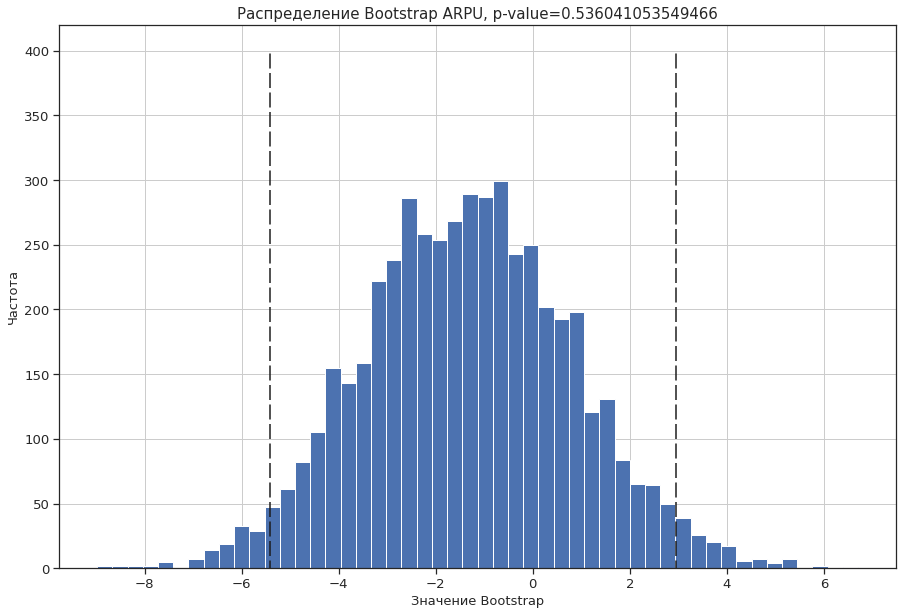

In [90]:
get_bootstrap(df_AB.query('testgroup == "a"').revenue, 
              df_AB.query('testgroup == "b"').revenue,
             'ARPU')

**Bootstrap** также не показал статисчически значимых различий между средними в выборках метрики **ARPU** (p-value > 0.05).

Проведём такой же анализ, убрав из тестовой выборки **уникальных пользователей**

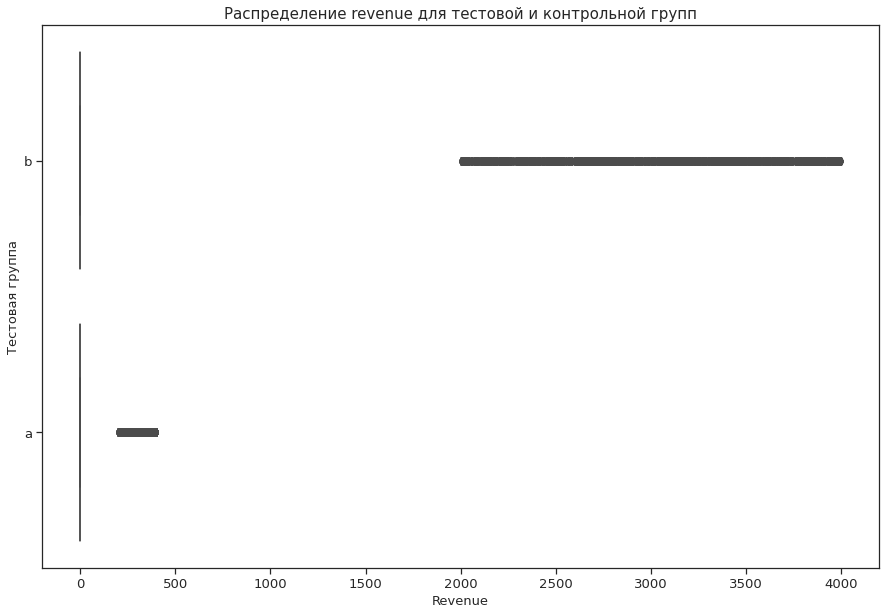

In [91]:
AB_ARPU = df_AB.query('revenue < 35000')
plt.figure(figsize=(15, 10))
ax = sns.boxplot(data=AB_ARPU, x='revenue', y='testgroup')
plt.title("Распределение revenue для тестовой и контрольной групп", fontsize=15)
ax.set_xlabel('Revenue', fontsize=13)
ax.set_ylabel('Тестовая группа', fontsize=13)
plt.show()

Обозначим гипотезы для проверки на нормальность распределения **тестом Шапиро-Уилка**:

**H0** - распределение метрики **ARPU** является нормальным

**H1** - распределение метрики **ARPU** не является нормальным

В качестве уровня значимости **α** выберем значение 0.05

In [92]:
shapiro(AB_ARPU.query('testgroup == "a"').revenue).pvalue

/opt/tljh/user/lib/python3.7/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


0.0

In [93]:
shapiro(AB_ARPU.query('testgroup == "b"').revenue).pvalue

0.0

Данные распределения также не являются нормальными, воспользуемся теми же тестами, что и в предыдущем шаге. Обозначим гипотезы для **U-критерия Манна-Уитни**:

**H0** - статистически значимых различий между ранжированными выборками метрики **ARPU** нет

**H1** - в ранжированных выборках метрики **ARPU** есть статистически значимые различия

В качестве уровня значимости **α** выберем значение 0.05

In [94]:
mannwhitneyu(AB_ARPU.query('testgroup == "a"').revenue,
             AB_ARPU.query('testgroup == "b"').revenue).pvalue

0.8675688044687636

**U-критерий Манна-Уитни** показал, что статистически значимых различий в ранжированных выборках нет (p > 0.05). 

Обозначим гипотезы для Bootstrap.

**H0** - различий между средними значениями метрики **ARPU** контрольной и тестовой групп нет.

**H1** - есть статистически значимые различия между средними значениями **ARPU** контрольной и тестовой групп.

В качестве уровня значимости **α** выберем значение 0.05

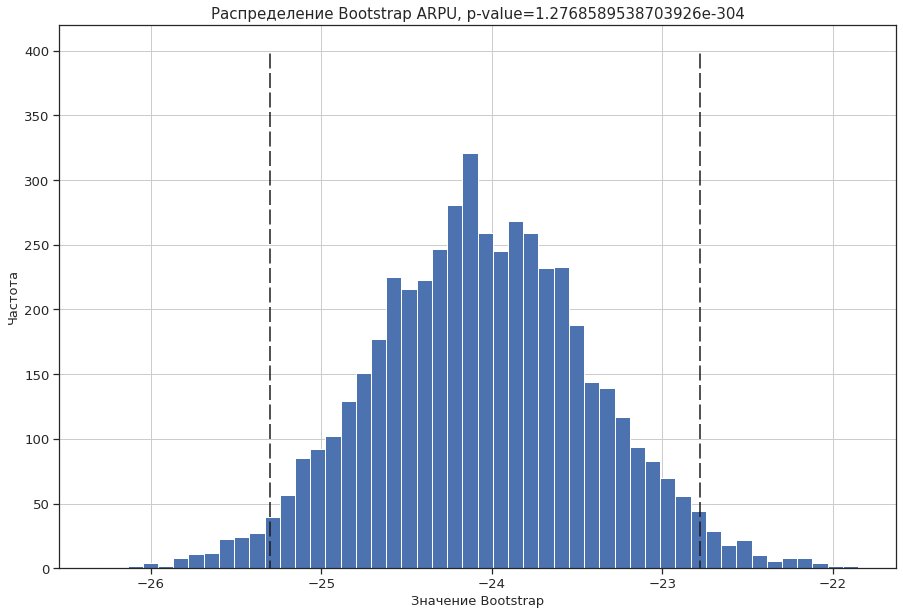

In [95]:
get_bootstrap(AB_ARPU.query('testgroup == "a"').revenue, 
              AB_ARPU.query('testgroup == "b"').revenue,
             'ARPU')

В отличии от **U-критерия Манна-Уитни** (p-value > 0.05), **Bootstrap** показал статисчически значимые различия между выборками метрики **ARPU** (p-value << 0.05). Учитывая большую надёжность **Bootstrap** считаю правильным использовать именно этот результат.

Таким образом, если не брать в расчёт **уникальных пользователей** то статистически значимые различия есть в метрике **ARPU**. Посмотрим какие именно.

In [96]:
res_ARPU = AB_ARPU.groupby('testgroup').agg(users_count=('user_id', 'count'),
                                total_revenue=('revenue', sum))
res_ARPU['ARPU'] = res_ARPU['total_revenue'] / res_ARPU['users_count']
res_ARPU

,users_count,total_revenue,ARPU
testgroup,,,
a,201980,545937,2.702926
b,202667,5421603,26.751287


### Вывод:

- Если рассматривать всех пользователей, то различий в доходе на одного пользователя в выборках нет
- Если не рассматривать уникальных пользователей в тестовой группе, то различия в доходе на одного пользователя есть. Метрика увеличилась в **9.9** раз.

# ARPPU

В обеих группах присутствует значительное количество пользователей, которые не совершают платежи. 
Для анализа метрики **ARPPU** мы исключим этих пользователей из расчетов. Также, как и для метрики **ARPU** проведём анализ с учётом **уникальных пользователей** тестовой группы и без них.

Построим боксплоты распределения **ARPPU**

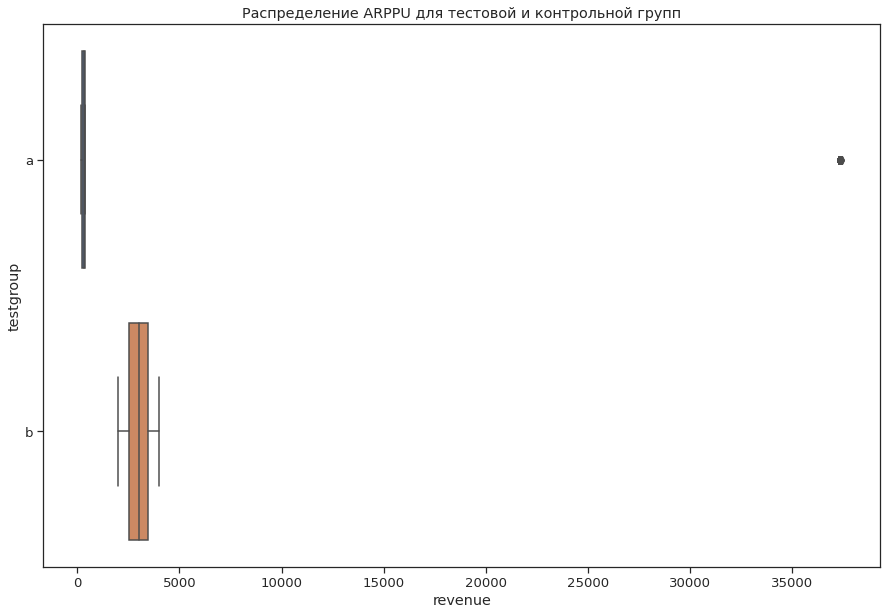

In [97]:
df_ARPPU = df_AB.query('revenue > 0')
plt.figure(figsize=(15, 10))
sns.boxplot(data=df_ARPPU, x='revenue', y='testgroup')
plt.title("Распределение ARPPU для тестовой и контрольной групп")
ax.set_xlabel('Revenue', fontsize=13)
ax.set_ylabel('Тестовая группа', fontsize=13)
plt.show()

Посмотрим на распределения **ARPPU** и проверим выборки на нормальность

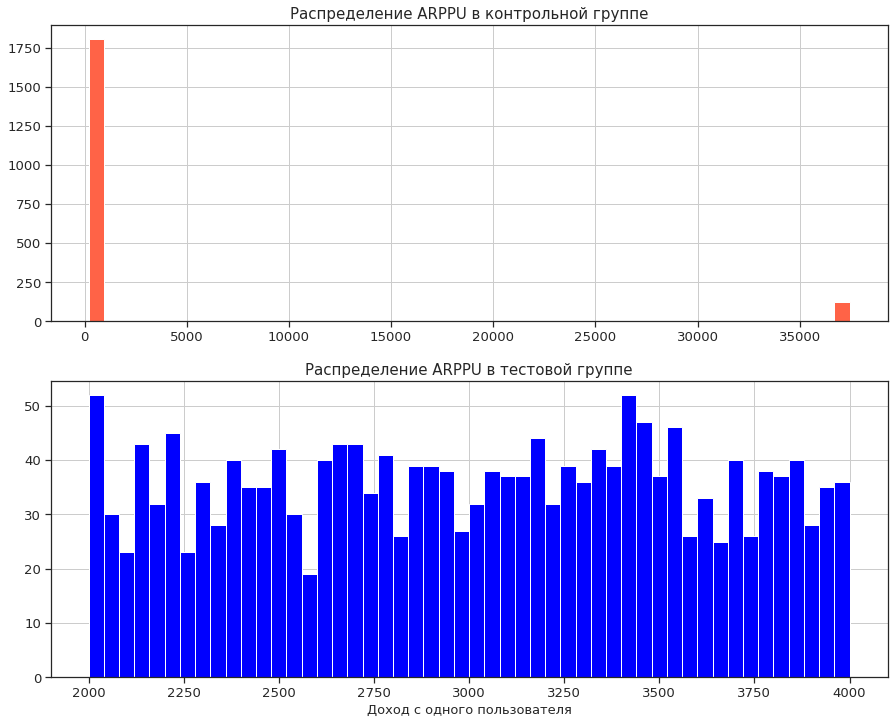

In [98]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(15, 12))
df_ARPPU.query('testgroup == "a"').revenue.hist(ax=axs[0], color='Tomato', bins=50)
axs[0].set_title('Распределение ARPPU в контрольной группе', fontsize=15)
df_ARPPU.query('testgroup == "b"').revenue.hist(ax=axs[1], color='Blue', bins=50)
axs[1].set_title('Распределение ARPPU в тестовой группе', fontsize=15)
axs[1].set_xlabel('Доход с одного пользователя', fontsize=13)
plt.show()

Обозначим гипотезы для проверки на нормальность распределения **критерием Шапиро-Уилка**:

**H0** - распределение метрики **ARPPU** является нормальным

**H1** - распределение метрики **ARPPU** не является нормальным

В качестве уровня значимости **α** выберем значение 0.05

In [99]:
shapiro(df_ARPPU.query('testgroup == "a"')['revenue']).pvalue

0.0

In [100]:
shapiro(df_ARPPU.query('testgroup == "a"')['revenue']).pvalue

0.0

**P-value** для обоих тестов меньше 0.05, это позволяет отвергнуть нулевую гипотезу. Значит распределения **ARPPU** в обеих группах не являются нормальными. Для нахождения статистически значемых различий между выборками воспользуемся **U-критерием Манна-Уитни** и **Bootstrap**. Обозначим гипотезы для **U-критерия Манна-Уитни**

**H0** - статистически значимых различий между ранжированными выборками метрики **ARPPU** нет

**H1** - в ранжированных выборках метрики **ARPPU** есть статистически значимые различия

В качестве уровня значимости **α** выберем значение 0.05

In [101]:
mannwhitneyu(df_ARPPU.query('testgroup == "a"').revenue, 
               df_ARPPU.query('testgroup == "b"').revenue).pvalue

0.0

**U-критерий Манна-Уитни** показал, что статистически значимых различия в ранжированных выборках есть (p-value < 0.05). 

Обозначим гипотезы для **Bootstrap**.

**H0** - различий между средними значениями метрики **ARPPU** контрольной и тестовой групп нет.

**H1** - есть статистически значимые различия между средними значениями **ARPPU** контрольной и тестовой групп.

В качестве уровня значимости **α** выберем значение 0.05

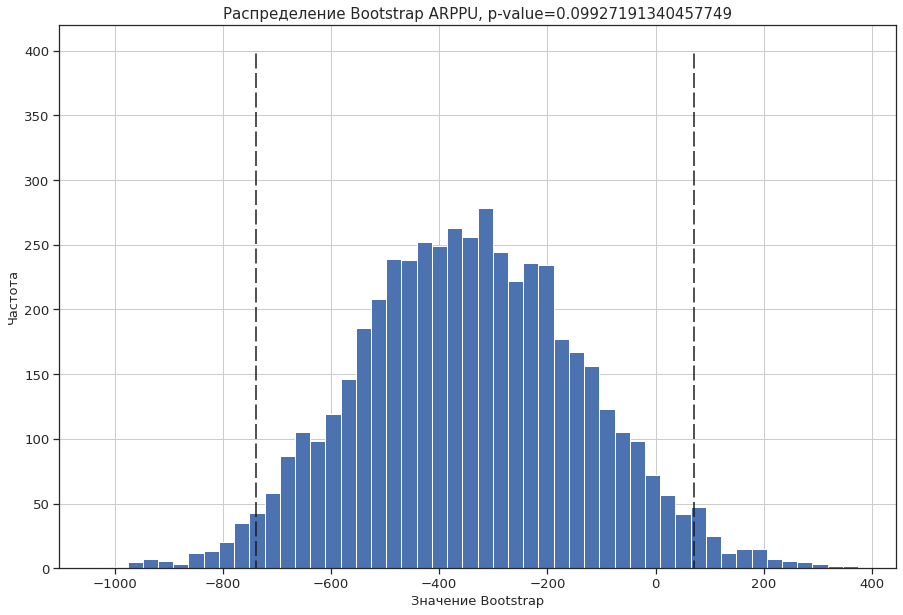

In [102]:
get_bootstrap(df_ARPPU.query('testgroup == "a"').revenue, 
               df_ARPPU.query('testgroup == "b"').revenue,
             'ARPPU')

В отличие от U-критерия Манна-Уитни (p-value < 0.05) Bootstrap не показал статистически значимых различий между средними в выборках метрики **ARPPU** (p-value > 0.05). 


Воспользуемся результатом **Bootstrap**: между тестовой и контрольной группами нет статисчтически значимых различий по метрике ARPPU.

Проведим такой же анализ убрав из выборок **уникальных пользователей** тестовой группы

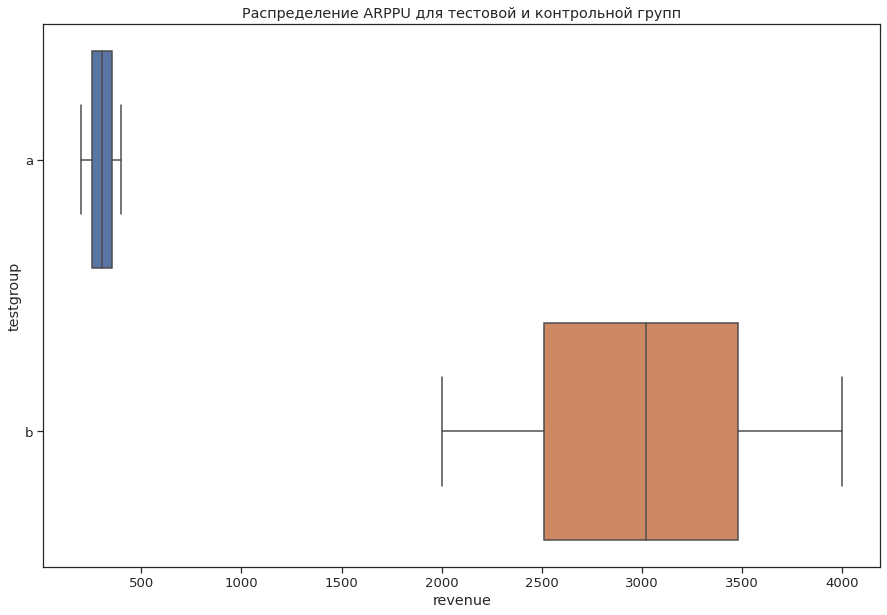

In [103]:
ARPPU_df = df_ARPPU.query('revenue < 35000')
plt.figure(figsize=(15, 10))
sns.boxplot(data=ARPPU_df, x='revenue', y='testgroup')
plt.title("Распределение ARPPU для тестовой и контрольной групп")
ax.set_xlabel('Revenue', fontsize=13)
ax.set_ylabel('Тестовая группа', fontsize=13)
plt.show()

В этот раз распределения уже похожи на нормальные. Посмотрим их распределения и проверим на нормальность

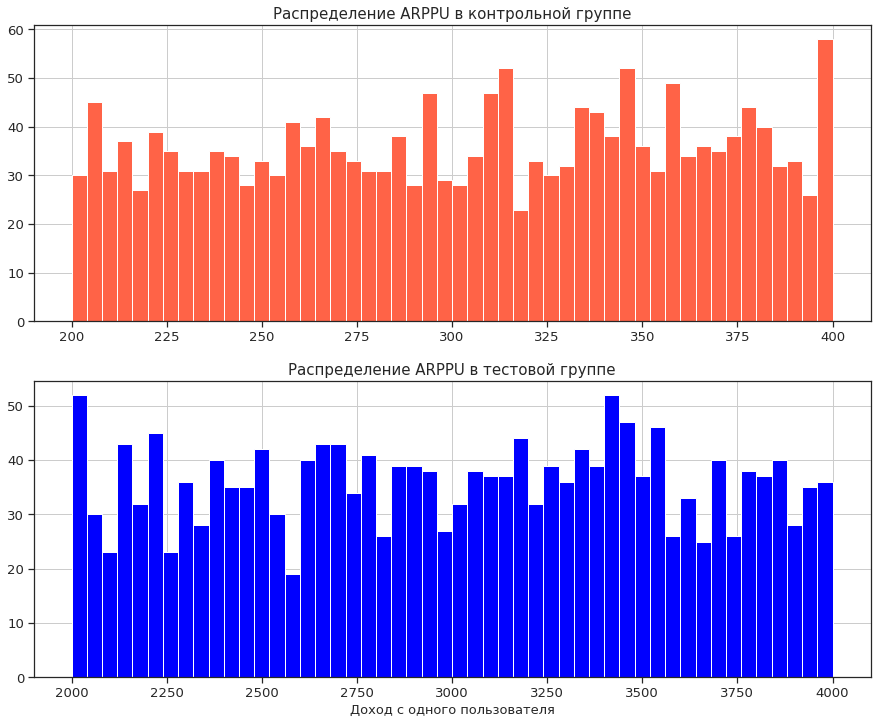

In [104]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(15, 12))
ARPPU_df.query('testgroup == "a"').revenue.hist(ax=axs[0], color='Tomato', bins=50)
axs[0].set_title('Распределение ARPPU в контрольной группе', fontsize=15)
ARPPU_df.query('testgroup == "b"').revenue.hist(ax=axs[1], color='Blue', bins=50)
axs[1].set_title('Распределение ARPPU в тестовой группе', fontsize=15)
axs[1].set_xlabel('Доход с одного пользователя', fontsize=13)
plt.show()

Обозначим гипотезы для проверки на нормальность распределения **критерием Шапиро-Уилка**:

**H0** - распределение метрики **ARPU** является нормальным

**H1** - распределение метрики **ARPU** не является нормальным

В качестве уровня значимости **α** выберем значение 0.05

In [105]:
shapiro(ARPPU_df.query('testgroup == "a"')['revenue']).pvalue

3.004845972000649e-23

In [106]:
shapiro(ARPPU_df.query('testgroup == "b"')['revenue']).pvalue

2.491345674771425e-22

**P-value** для обоих тестов меньше 0.05, это позволяет отвергнуть нулевую гипотезу. Значит распределения **ARPPU** в обеих группах не являются нормальными. Для нахождения статистически значимых различий между выборками воспользуемся **U-критерием Манна-Уитни** и **Bootstrap**. 

Обозначим гипотезы для **U-критерия Манна-Уитни**

**H0** - статистически значимых различий между ранжированными выборками метрики **ARPPU** нет

**H1** - в ранжированных выборках метрики **ARPPU** есть статистически значимые различия

В качестве уровня значимости **α** выберем значение 0.05

In [107]:
mannwhitneyu(ARPPU_df.query('testgroup == "a"').revenue, 
               ARPPU_df.query('testgroup == "b"').revenue).pvalue

0.0

**U-критерий Манна-Уитни** показал, что статистически значимых различия в ранжированных выборках есть (p-value < 0.05). 

Обозначим гипотезы для Bootstrap.

**H0** - различий между средними значениями метрики **ARPPU** контрольной и тестовой групп нет.

**H1** - есть статистически значимые различия между средними значениями **ARPPU** контрольной и тестовой групп.

В качестве уровня значимости **α** выберем значение 0.05

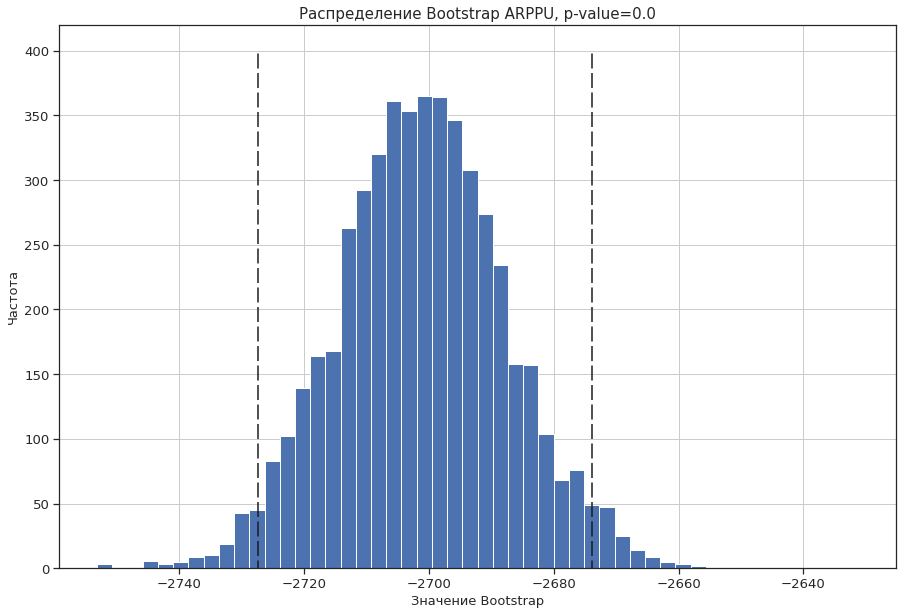

In [108]:
get_bootstrap(ARPPU_df.query('testgroup == "a"').revenue, 
               ARPPU_df.query('testgroup == "b"').revenue,
             'ARPPU')

**P-value U-критерия Манна-Уитни** и **Bootstrap** показали статисчически значимые различия между выборками по метрике **ARPPU** (p-value << 0.05). 

Таким образом между тестовой и контрольной группой есть статисчтически значимые различия по метрике ARPPU.

Найдём конкретное значение. Сгруппируем датафрейм по группе и посчитаем количество пользователей и общую прибыль. Разделим получившуюся прибыль на количество пользователей.

In [109]:
ARPPU_res = ARPPU_df.groupby('testgroup').agg(users_count=('user_id', 'count'),
                                total_revenue=('revenue', sum))
ARPPU_res['ARPPU'] = ARPPU_res['total_revenue'] / ARPPU_res['users_count']
ARPPU_res

,users_count,total_revenue,ARPPU
testgroup,,,
a,1805,545937,302.458172
b,1805,5421603,3003.658172


### Вывод:

- Если рассматривать всех пользователей, количество прибыли от одного платящего пользователя в тестовой и контрольной группах не изменилось
- Если не рассматривать уникальных **123** (**0.002%**) пользователя в тестовой группе, которые принесли большую часть прибыли (**89.4%**), то различия в доходе на одного платящего пользователя есть. Данная метрика увеличилась в 9.9 раз.

## Конверсия в покупку

Для проверки статистически значимых различий приведём параметр "платящий/не платящий" к дискретному виду и воспользумся критерием **Хи-квадрат**. Добавим столбец **is_paying**, в который запишем 1, если пользователь платящий, иначе - 0. Также проведём анализ с учетом и без учёта **уникальных пользователей** тестовой грппы.

In [110]:
df_AB['is_paying'] = np.where(df_AB['revenue'] > 0, 1, 0)

Сгруппируем датафрейм по группам и посчитаем количество платящих пользователей и суммарное количество пользователей. Оставим только необходимые для анализа столбцы.

In [111]:
purchase_conversion = df_AB.groupby('testgroup').agg(pay_users_count=('is_paying', sum),
                                               users_count=('is_paying', 'count'))[['pay_users_count', 'users_count']]
purchase_conversion

,pay_users_count,users_count
testgroup,,
a,1928,202103
b,1805,202667


Обозначим гипотезы и уровень значимости для **критерия Хи-квадрат**:
   
**H0** - статистически значимых различий между теоритическим и фактическим значением конверсии в покупкунет

**H1** - в выборках есть статистически значимые различия теоритического и фактического значения конверсии в покупку

В качестве уровня значимости **α** выберем значение 0.05

In [112]:
chi2_contingency(purchase_conversion)[1]

0.03824373651044168

**p-value** меньше заданного уровня значимости, что **позволяет отвергнуть** нулевую гипотезу **H0**. Между исследуемыми выборками (контрольной и тестовой групп) есть статистически значимые различия. Расчитаем как изменилась конверсия в покупку.

In [113]:
100 * (1805/202667 - 1928/202103)

-0.06334548064021554

Конверсия в покупку уменьшилась на 0.06%

Проведём такой же алгоритм без учёта **уникальных пользователей**

In [114]:
purchase_conversion = df_AB.query('revenue < 35000').groupby('testgroup').agg(pay_users_count=('is_paying', sum),
                                               users_count=('is_paying', 'count'))[['pay_users_count', 'users_count']]
purchase_conversion

,pay_users_count,users_count
testgroup,,
a,1805,201980
b,1805,202667


Обозначим гипотезы и уровень значимости для **критерия Хи-квадрат**:
   
**H0** - статистически значимых различий между теоритическим и фактическим значением конверсии в покупкунет

**H1** - в выборках есть статистически значимые различия теоритического и фактического значения конверсии в покупку

В качестве уровня значимости **α** выберем значение 0.05

In [115]:
chi2_contingency(purchase_conversion)[1]

0.9323898467843289

- **p-value** больше заданного уровня значимости, что **не позволяет отвергнуть** нулевую гипотезу **H0**
- Статистически значимых различий между тестовой и контрольной группами по конверсии в покупку без учёта уникальных пользователей нет 

# ВЫВОДЫ


- В качестве метрик для анализа, проведённого A/B теста были выбраны ARPU, ARPPU и Конверсия в покупку
- При анализе данных были обнаружены 123 (0.002%) пользователя тестовой группы, которые принесли в тестовой группе большую часть прибыли (89.4%). Для принятия решения по A/B тесту необходимо выяснить, что это за пользователи, возможно это ошибка в данных.
- Был проведён анализ дат регистрации пользователей в двух группах. Из данного анализа стало понятно, что в тестовой группе были более "новые" пользователи. Это может говорить о том, что выборки могут быть нерепрезентативны. Данный анализ имеет место быть, если id пользователей в предыдущем и текущем задании совпадают.
- Общий доход в тестовой группе на 5.6% больше, чем в контрольной
- Если рассматривать всех пользователей, то:
    - Различий в доходе на одного пользователя в выборках нет
    - Количество прибыли от одного платящего пользователя не изменилось
    - Конверсия в покупку уменьшилась на 0.06%
- Если не рассматривать уникальных пользователей в тестовой группе, то:
    - Доход на одного пользователя увеличился в 9.9 раз. 
    - Доход на одного платящего пользователя увеличился в 9.9 раз.
    - Конверсия в покупку не изменилась
- Считаю, что можно выкатывать версию B, т.к. хоть конверсия в покупку и изменилась в худшую сторону, но не сильно.

# 4. Метрики

В игре **Plants & Gardens** каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. Необходимо перечислить метрики для оценки результатов прошедшего события.

### Метрики, с помощью которых можно оценить результаты последнего прошедшего события:
- **Revenue** – суммарная прибыль от проведённого тематического события;
- **DAU / WAU / MAU**  - количество уникальных игроков, которые авторизовались в игре (или совершили иное целевое действие)  во время тематическое события (в день/неделю/месяц);
- **Sticky Factor** («Липкость») -  отношение DAU к MAU. Данная метрика позволит оценить регулярность авторизаций и стабильность пользовательской базы, также характеризует лояльность и активность игроков;
- **Retention Rate** (коэффициент удержания пользователей) метрика покажет количество игроков, которые вернулись в игру после прохождения тематического события; 
- **Churn Rate** (коэффициент оттока) - обратная метрика для Retention Rate;
- **ARPU** (Average Revenue Per User) - средняя прибыль с одного игрока за время тематического события;
- **ARPPU** (Average Revenue Per Paying User) - средняя прибыль с одного платящего пользователя за конкретный период. 
- **Воронка** и всевозможные **конверсии** из этапа в этап - процент игроков, которые продолжают играть в игру после прохождения каждого из возможных этапов:
    - Первая авторизация во время тематического события
    - Прохождение 1ого уровня
    - Прохождение 2ого уровня 
    - …
    - Прохождение n-ого уровня
    - Получение уникальных предметов для сада и персонажей, дополнительные монеты или бонусы
    - …
    - Покупка в магазине (?)
    - Прохождение последнего уровня;
- **Количество и разновидность выданных уникальных предметов или бонусов** - показывает, насколько успешными были награды, и стимулируют ли эти награды игроков к участию в событии;
- **Удовлетворенность игроков** (оценка события) – метрика покажет общее впечатление от события, в том числе относительно других событий;
- Также можно провести **когортный анализ**, чтобы отследить, как игроки из разных когорт отреагировали на данное тематическое событие.

Предположим, в другом событии механика событий была усложненна таким образом, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

### Для оценки тематического события можно использовать те же метрики, причём, каждую из них можно будет разбить на две группы: для игроков, получивших "откат" на несколько уровней и для не получивших. Также можно добавить несколько новых метрик:

1. **Количество игроков, успешно завершивших все уровни с откатом** - поможет оценить уровень сложности и уровень вовлеченности игроков;
2. **Количество игроков, которые приостановили участие в событии после нескольких неудачных попыток** - показывает, насколько изменение механики повлияло на мотивацию игроков и их продолжение участия в событии;
3. **Среднее количество попыток, которое требуется игрокам для успешного прохождения уровней с откатом** - помогает оценить уровень сложности и возможность прогресса для игроков;
4. **Время, затраченное на прохождение уровней с откатом, в сравнении с предыдущими событиями** - позволяет оценить, насколько изменение механики повлияло на длительность участия игроков.